# Inference Kernel Demo

This is the kernel I’ve used for my recent submissions. It takes about 5-6 hours on the test set, using only CPU. 

I’ve provided this kernel because a lot of people have problems making submissions. This method works and has never errored out for me. (Although I haven't tried making a submission using the GPU yet -- so no guarantees there.)

It uses BlazeFace for face extraction (see also [my BlazeFace kernel](https://www.kaggle.com/humananalog/starter-blazeface-pytorch)) and ResNeXt50 as the classifier model.

We take the average prediction over 17 frames from each video. (Why 17? Using more frames makes the kernel slower, but doesn't appear to improve the score much. I used an odd number so we don't always land on even frames.)

**Please use this kernel only to learn from...** Included is the checkpoint for a ResNeXt50 model that hasn't really been trained very well yet. I'm sure you can improve on it by training your own model!

You could use the included trained weights to get yourself an easy top-50 score on the leaderboard (as of 24 Jan 2020) but it’s nicer to use it as a starting point for your own work. :-)

In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image, ImageStat, ImageEnhance

## Get the test videos

In [2]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

## Create helpers

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [4]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [5]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")

from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [6]:
def read_frames(path):
    v_cap = cv2.VideoCapture(path)
    v_int = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if v_int <= 0: return None

    frame_idxs = np.linspace(0, v_int - 1, frames_per_vid, endpoint=True, dtype=np.int)

    result = []
    for i in range(v_int):
        ret = v_cap.grab()
        if ret is None:
            continue
            
        if i in frame_idxs:
            ret, frame = v_cap.retrieve()
            if ret is None or frame is None:
                continue
    
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result.append(frame)
            
    v_cap.release()
    return np.array(result)

In [7]:
class FaceExtractor:
    
    def __init__(self, video_read_fn, facedet):

        self.video_read_fn = video_read_fn
        self.facedet = facedet
    
    def process_video(self, video_path):
        """Convenience method for doing face extraction on a single video."""
 
        result = []
    
        target_size = self.facedet.input_size
        
        # 1 - get frames
        frames = self.video_read_fn(video_path)
        # Error? Then skip this video.
        if frames is None: return result
            
            
        # 2 - split the frames into several tiles. Resize the tiles to 128x128.
        tiles, resize_info = self._tile_frames(frames, target_size)
        
        
        # 3 - Run the face detector. The result is a list of PyTorch tensors, 
        # one for each image in the batch.
        detections = self.facedet.predict_on_batch(tiles, apply_nms=False)
        
        # 3 - convert the detections from 128x128 back to the original frame size.
        detections = self._resize_detections(detections, target_size, resize_info)
        
        
        # 4 - Because we have several tiles for each frame, combine the predictions
        # from these tiles. The result is a list of PyTorch tensors, but now one
        # for each frame (rather than each tile).
        num_frames = frames.shape[0]
        frame_size = (frames.shape[2], frames.shape[1])
        detections = self._untile_detections(num_frames, frame_size, detections)
        
         
        # 5 - The same face may have been detected in multiple tiles, so filter out
        # overlapping detections. This is done separately for each frame.
        detections = self.facedet.nms(detections)
        
        
        for i in range(len(detections)):
            # Crop the faces out of the original frame.
            faces = self._add_margin_to_detections(detections[i], frame_size, 0.2)
            faces = self._crop_faces(frames[i], faces)

            # Add additional information about the frame and detections.
            scores = list(detections[i][:, 16].cpu().numpy())
            frame_dict = { "frame_w": frame_size[0],
                            "frame_h": frame_size[1],
                            "faces": faces, 
                            "scores": scores }
            result.append(frame_dict)
        
        
        return result


    def _tile_frames(self, frames, target_size):

        num_frames, H, W, _ = frames.shape

        # Settings for 6 overlapping windows:
        # split_size = 720
        # x_step = 480
        # y_step = 360
        # num_v = 2
        # num_h = 3

        # Settings for 2 overlapping windows:
        # split_size = min(H, W)
        # x_step = W - split_size
        # y_step = H - split_size
        # num_v = 1
        # num_h = 2 if W > H else 1

        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        splits = np.zeros((num_frames * num_v * num_h, target_size[1], target_size[0], 3), dtype=np.uint8)

        i = 0
        for f in range(num_frames):
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    crop = frames[f, y:y+split_size, x:x+split_size, :]
                    splits[i] = cv2.resize(crop, target_size, interpolation=cv2.INTER_AREA)
                    x += x_step
                    i += 1
                y += y_step

        resize_info = [split_size / target_size[0], split_size / target_size[1], 0, 0]
        return splits, resize_info

    def _resize_detections(self, detections, target_size, resize_info):

        projected = []
        target_w, target_h = target_size
        scale_w, scale_h, offset_x, offset_y = resize_info

        for i in range(len(detections)):
            detection = detections[i].clone()

            # ymin, xmin, ymax, xmax
            for k in range(2):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_h - offset_y) * scale_h
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_w - offset_x) * scale_w

            # keypoints are x,y
            for k in range(2, 8):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_w - offset_x) * scale_w
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_h - offset_y) * scale_h

            projected.append(detection)

        return projected    
    
    def _untile_detections(self, num_frames, frame_size, detections):

        combined_detections = []

        W, H = frame_size
        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        i = 0
        for f in range(num_frames):
            detections_for_frame = []
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    # Adjust the coordinates based on the split positions.
                    detection = detections[i].clone()
                    if detection.shape[0] > 0:
                        for k in range(2):
                            detection[:, k*2    ] += y
                            detection[:, k*2 + 1] += x
                        for k in range(2, 8):
                            detection[:, k*2    ] += x
                            detection[:, k*2 + 1] += y

                    detections_for_frame.append(detection)
                    x += x_step
                    i += 1
                y += y_step

            combined_detections.append(torch.cat(detections_for_frame))

        return combined_detections
    
    def _add_margin_to_detections(self, detections, frame_size, margin=0.2):

        offset = torch.round(margin * (detections[:, 2] - detections[:, 0]))
        detections = detections.clone()
        detections[:, 0] = torch.clamp(detections[:, 0] - offset*2, min=0)            # ymin
        detections[:, 1] = torch.clamp(detections[:, 1] - offset, min=0)              # xmin
        detections[:, 2] = torch.clamp(detections[:, 2] + offset, max=frame_size[1])  # ymax
        detections[:, 3] = torch.clamp(detections[:, 3] + offset, max=frame_size[0])  # xmax
        return detections
    
    def _crop_faces(self, frame, detections):
        """Copies the face region(s) from the given frame into a set
        of new NumPy arrays.

        Arguments:
            frame: a NumPy array of shape (H, W, 3)
            detections: a PyTorch tensor of shape (num_detections, 17)

        Returns a list of NumPy arrays, one for each face crop. If there
        are no faces detected for this frame, returns an empty list.
        """
        faces = []
        for i in range(len(detections)):
            ymin, xmin, ymax, xmax = detections[i, :4].cpu().numpy().astype(np.int)
            face = frame[ymin:ymax, xmin:xmax, :]
            faces.append(face)
        return faces

    def remove_large_crops(self, crops, pct=0.1):

        for i in range(len(crops)):
            frame_data = crops[i]
            video_area = frame_data["frame_w"] * frame_data["frame_h"]
            faces = frame_data["faces"]
            scores = frame_data["scores"]
            new_faces = []
            new_scores = []
            for j in range(len(faces)):
                face = faces[j]
                face_H, face_W, _ = face.shape
                face_area = face_H * face_W
                if face_area / video_area < 0.1:
                    new_faces.append(face)
                    new_scores.append(scores[j])
            frame_data["faces"] = new_faces
            frame_data["scores"] = new_scores

    def keep_only_best_face(self, crops):

        for i in range(len(crops)):
            frame_data = crops[i]
            if len(frame_data["faces"]) > 0:
                frame_data["faces"] = frame_data["faces"][:1]
                frame_data["scores"] = frame_data["scores"][:1]

    # TODO: def filter_likely_false_positives(self, crops):
    #   if only some frames have more than 1 face, it's likely a false positive
    #   if most frames have more than 1 face, it's probably two people
    #   so find the % of frames with > 1 face; if > 0.X, keep the two best faces

    # TODO: def filter_by_score(self, crops, min_score) to remove any
    # crops with a confidence score lower than min_score

    # TODO: def sort_by_histogram(self, crops) for videos with 2 people.

In [8]:
frames_per_vid = 64
input_size = 224

video_read_fn = lambda x: read_frames(x)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [9]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [10]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [11]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)
        in_features = self.fc.in_features
    
#         self.fc = nn.Sequential(
#             nn.BatchNorm1d(in_features),
#             nn.Dropout(),
#             nn.Linear(in_features, in_features//2),
#             nn.ReLU(),
            
#             nn.BatchNorm1d(in_features//2),
#             nn.Dropout(),
#             nn.Linear(in_features//2, in_features//4),
#             nn.ReLU(),
            
#             nn.BatchNorm1d(in_features//4),
#             nn.Dropout(),
#             nn.Linear(in_features//4, 1),
#         )


In [12]:
checkpoint = torch.load('../input/dfdcresnetxt2020327/best_model_.pth', map_location=gpu)

model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint['state_dict'])
_ = model.eval()

del checkpoint

## Prediction loop

In [13]:
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [14]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_vid)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

## Speed test

The leaderboard submission must finish within 9 hours. With 4000 test videos, that is `9*60*60/4000 = 8.1` seconds per video. So if the average time per video is greater than ~8 seconds, the kernel will be too slow!

In [15]:
speed_test = True  # you have to enable this manually

In [16]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 24.957580 sec. Average per video: 4.991516 sec.


## Make the submission

In [17]:
predictions = predict_on_video_set(test_videos, num_workers=4)

In [18]:
submission_df = pd.DataFrame({"filename": test_videos, "label": predictions})

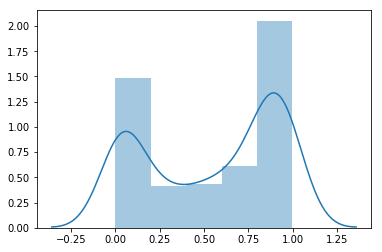

In [19]:
import seaborn as sns
sns.distplot(predictions)

# post-processing
clip (0.1, 0.9) <br>
change 0.5 to 0.481

In [20]:
# clip
submission_df['label'] = submission_df['label'].clip(0.1, 0.9)

(array([118.,  10.,  12.,  13.,  13.,  20.,  14.,  17.,  29., 154.]),
 array([0.1 , 0.18, 0.26, 0.34, 0.42, 0.5 , 0.58, 0.66, 0.74, 0.82, 0.9 ]),
 <a list of 10 Patch objects>)

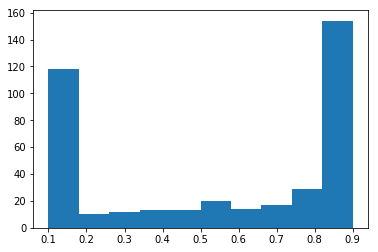

In [21]:
# check clip
plt.hist(submission_df['label'])

In [22]:
# change 0.5 to 0.481
submission_df = submission_df.replace(0.5, 0.481)

In [23]:
# save the file
submission_df.to_csv("submission.csv", index=False)

In [24]:
# check submission
df = pd.read_csv('submission.csv')
df.head()

,filename,label
0,aassnaulhq.mp4,0.900000
1,aayfryxljh.mp4,0.100000
2,acazlolrpz.mp4,0.900000
3,adohdulfwb.mp4,0.100000
4,ahjnxtiamx.mp4,0.544563


(array([118.,  10.,  12.,  13.,  15.,  18.,  14.,  17.,  29., 154.]),
 array([0.1 , 0.18, 0.26, 0.34, 0.42, 0.5 , 0.58, 0.66, 0.74, 0.82, 0.9 ]),
 <a list of 10 Patch objects>)

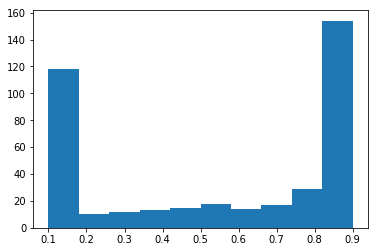

In [25]:
plt.hist(df['label'])